In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import seaborn as sns
from sklearn.linear_model import LinearRegression

%matplotlib notebook

In [3]:
def create_sign_func(line):
    def sign_func(point):
        if np.dot(line, [1, point[0], point[1]]) > 0:
            return 1
        elif np.dot(line, [1, point[0], point[1]]) < 0:
            return -1
        else:
            return 0
        
    return sign_func


def convert_to_explicit_eq(vector):
    return np.poly1d([-vector[1]/vector[2], -vector[0]/vector[2]])


def generate_sample(sample_size):
    p1 = np.random.uniform(-1, 1, 2)
    p2 = np.random.uniform(-1, 1, 2)
    
    v = p1 - p2
    n = (-v[1], v[0])
    line = np.array([-n[0]*p1[0] - n[1]*p1[1], n[0], n[1]])
    target_func = create_sign_func(line)
    
    sample = pd.DataFrame({
        'X': np.random.uniform(-1, 1, sample_size + 100),
        'Y': np.random.uniform(-1, 1, sample_size + 100),
    })

    sample['Sign'] = sample[['X', 'Y']].apply(target_func, axis = 1)
    
    
    return sample, line, target_func

In [4]:
sample, line, target_func = generate_sample(100)
training = sample
sample.head()

,X,Y,Sign
0,-0.451918,0.353858,-1
1,-0.064039,-0.252040,-1
2,0.130112,-0.228089,-1
3,0.987334,-0.371461,-1
4,-0.430696,0.404749,1


In [5]:
regr = LinearRegression()
regr.fit(sample[['X', 'Y']], sample.Sign)
regr_explicit = convert_to_explicit_eq([regr.intercept_, regr.coef_[0], regr.coef_[1]])
line_explicit = convert_to_explicit_eq(line)
print("Target function: ", line_explicit)
print("Linear regression: ", regr_explicit)

Target function:   
-0.3856 x + 0.2367
Linear regression:   
-0.3407 x + 0.1382


<IPython.core.display.Javascript object>


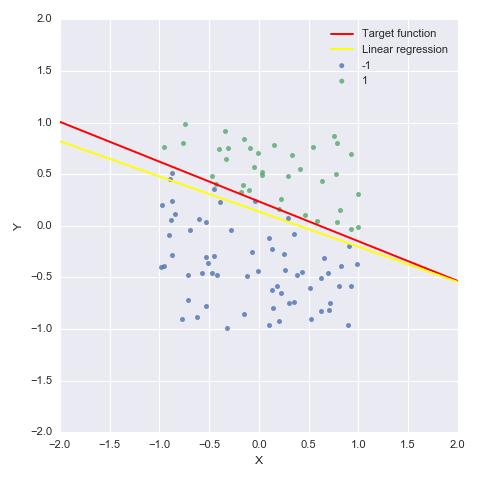

In [6]:
sns.lmplot('X', 'Y', data = sample, hue='Sign', fit_reg=False, legend_out=False, size = 6)
x = np.linspace(-2, 2, 100)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot(x, line_explicit(x), color="red", label="Target function")
plt.plot(x, regr_explicit(x), color="yellow", label="Linear regression")
plt.legend()

In [7]:
def run_experiment_for_errors(sample_size):
    runs = 1000
    ein = 0
    eout = 0
    
    for _ in range(runs):
        regr = LinearRegression()
        sample, line, target_func = generate_sample(sample_size)
        regr.fit(sample[['X', 'Y']], sample.Sign)
        
        regr_sign_func = create_sign_func([regr.intercept_, regr.coef_[0], regr.coef_[1]])
        
        # In sample error
        sample['Regr_sign'] = sample[['X', 'Y']].apply(regr_sign_func, axis = 1)
        ein += sample[sample.Sign != sample.Regr_sign].shape[0] / sample_size
        
        # Out of sample error
        out_of_sample_size = 1000
        out_of_sample = pd.DataFrame({
            'X': np.random.uniform(-1, 1, out_of_sample_size),
            'Y': np.random.uniform(-1, 1, out_of_sample_size),
        })

        out_of_sample['Sign'] = out_of_sample[['X', 'Y']].apply(target_func, axis = 1)
        out_of_sample['Regr_sign'] = out_of_sample[['X', 'Y']].apply(regr_sign_func, axis = 1)
        eout += out_of_sample[out_of_sample.Sign != out_of_sample.Regr_sign].shape[0] / out_of_sample_size
    
    # Final solution
    ein, eout = ein / runs, eout / runs
    print("N: ", sample_size)
    print("Avarage in sample error: ", ein)
    print("Avarage out of sample error: ", eout)

### Solutions to questions 5 and 6 :

In [8]:
run_experiment_for_errors(100)

N:  100
Avarage in sample error:  0.0392500000000001
Avarage out of sample error:  0.04952000000000004


In [9]:
def perceptron_algorithm(sample, initial_vector):
    h = initial_vector
    n = sample.X.size
    i = j = num_it = 0
    while(j < n):
        sign = sample.iloc[i].Sign
        dot_product = np.dot(h, [1, sample.iloc[i].X, sample.iloc[i].Y])
        if dot_product > 0: new_sign = 1
        elif dot_product < 0: new_sign = -1
        else: new_sign = 0
        if new_sign == sign:
            i, j = (i + 1) % n, j + 1
        else:
            h = h + sign * np.array([1, sample.iloc[i].X, sample.iloc[i].Y])
            i, j = (i + 1) % n, 0
            num_it += 1
    
    return h, num_it


def run_experiment_for_perceptron(sample_size):
    runs = 1000
    sum_num_it = 0
    
    for _ in range(runs):
        regr = LinearRegression()
        sample, line, target_func = generate_sample(sample_size)
        regr.fit(sample[['X', 'Y']], sample.Sign)
        initial_vector = np.append(regr.intercept_, regr.coef_)
        perceptron, num_it = perceptron_algorithm(sample, initial_vector)
        sum_num_it += num_it
        
    print ("Avarage number of perceptorn iterations: ", sum_num_it / runs)

### Solution to question 7 :

In [10]:
run_experiment_for_perceptron(10)

Avarage number of perceptorn iterations:  6.072
